# Libraries

In [2]:
import pandas as pd
import numpy as np
import calendar
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import warnings
warnings.filterwarnings("ignore")
import time
import re

In [3]:
import sys
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
import tensorflow as tf
gpu = len(tf.config.list_physical_devices('GPU'))>0
from tensorflow import keras
from keras.models import Sequential 
from keras.layers import Dense, Activation, Input
import keras.backend as K 
print(gpu)

True


In [2]:
df_1991 = pd.read_csv("./dataset/1991.csv",  encoding='latin-1')
df_2001 = pd.read_csv("./dataset/2001.csv",  encoding='latin-1')

In [3]:
df_airport = pd.read_csv("./dataset/airports.csv")
df_carriers = pd.read_csv("./dataset/carriers.csv")

# Flight Data

https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/HG7NV7

Variable descriptions: 

1 Year 1987-2008 **useuful**

2 Month 1-12 **useuful**

3 DayofMonth 1-31 **useuful**

4 DayOfWeek 1 (Monday) - 7 (Sunday) **useuful**

5 DepTime actual departure time (local, hhmm) **useuful**

6 CRSDepTime scheduled departure time (local, hhmm) **useuful**

7 ArrTime actual arrival time (local, hhmm) **useuful**

8 CRSArrTime scheduled arrival time (local, hhmm) **useuful**

9 UniqueCarrier unique carrier code **useuful**

10 FlightNum flight number **useuful**

11 TailNum plane tail number **not useful (1991 has 100% null)**

12 ActualElapsedTime in minutes **not useuful (ArrTime - DepTime)**

13 CRSElapsedTime in minutes **useuful, it's the expected flight duration**

14 AirTime in minutes **not useuful**

15 ArrDelay arrival delay, in minutes **useuful (on time flight has ArrDelay = 0, It's our target variable for classification)**

16 DepDelay departure delay, in minutes **useuful (might be associated to ArrDelay)**

17 Origin origin IATA airport code **useuful**

18 Dest des tination IATA airport code **useuful**

19 Distance in miles **not useuful**

20 TaxiIn taxi in time, in minutes **not useuful**

21 TaxiOut taxi out time in minutes **not useuful**

22 Cancelled was the flight cancelled? **not useuful (we are not interested in cancelled flights. To remove rows if = 1)**

23 CancellationCode reason for cancellation (A = carrier, B = weather, C = NAS, D = security) **not useuful (all null)**

24 Diverted 1 = yes, 0 = no **not useuful (we are not interested in cancelled flights. To remove rows if = 1)**

25 CarrierDelay in minutes **not useuful (all null)**

26 WeatherDelay in minutes **not useuful (all null)**

27 NASDelay in minutes **not useuful (all null)**

28 SecurityDelay in minutes **not useuful (all null)**

29 LateAircraftDelay in minutes **not useuful (all null)**

Compare 1991 and 2001 with respect to:
- What characterises flights that are on time? (descriptive) --> **On time means that the arrivalDelay = 0**
    - Exploratory analysis + clustering
- Add your own analytics (predictive, prescriptive) question and answer it.
    - Predictive: How can we predict if a flight will arrive on time? Classification problem
    - Prescriptive: What should we improve in order to increase the % of on time arrivals?

DepDelay indicates the delay of the flight related to the scheduled departure time (CRSDepTime) at the airport 'X-1'

ArrDelay indicates the delay of the flight related to the scheduled arrival time (CRSArrTime) at the airport 'X'

So the flights are from airport 'X-1' to 'X'

In [144]:
df_1991[["DepTime", "CRSDepTime", "ArrTime", "CRSArrTime", "ArrDelay", "DepDelay", "CRSElapsedTime"]]

,DepTime,CRSDepTime,ArrTime,CRSArrTime,ArrDelay,DepDelay,CRSElapsedTime
0,1709.0,1705,1944.0,1944,0.0,4.0,159
1,1704.0,1705,1946.0,1944,2.0,-1.0,159
2,1705.0,1705,1934.0,1944,-10.0,0.0,159
3,1709.0,1705,1951.0,1944,7.0,4.0,159
4,1703.0,1705,1936.0,1944,-8.0,-2.0,159
...,...,...,...,...,...,...,...
5076920,1130.0,1130,1413.0,1359,14.0,0.0,149
5076921,1130.0,1130,1353.0,1359,-6.0,0.0,149
5076922,1128.0,1130,1356.0,1359,-3.0,-2.0,149
5076923,1130.0,1130,1402.0,1359,3.0,0.0,149


example over the first flight:

- CRSDepTime = 17:05
- DepTime = 17:09
- We have 4 minutes of departure delay = DepDelay

- CRSArrTime = 19:44
- ArrTime = 19:44
- We have 0 minutes of arrival delay = ArrDelay

So first the is the departure, then the arrival. This means that the departure is from airport X-1 and the arrival at airport X

The CRSElapsedTime is the flight duration as it was scheduled. Example:

19.44 - 17.05 = 159'

**CRSElapsedTime = CRSArrTime - CRSDepTime**

The ActualElapsedTime is the actual flight duration.

**ActualElapsedTime = ArrTime - DepTime**

## Pre-processing

In [4]:
df_1991

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,1991,1,1,2,1709.0,1705,1944.0,1944,US,112,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,1991,1,2,3,1704.0,1705,1946.0,1944,US,112,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,1991,1,3,4,1705.0,1705,1934.0,1944,US,112,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN
3,1991,1,4,5,1709.0,1705,1951.0,1944,US,112,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4,1991,1,5,6,1703.0,1705,1936.0,1944,US,112,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5076920,1991,12,8,7,1130.0,1130,1413.0,1359,CO,1550,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN
5076921,1991,12,9,1,1130.0,1130,1353.0,1359,CO,1550,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN
5076922,1991,12,10,2,1128.0,1130,1356.0,1359,CO,1550,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN
5076923,1991,12,11,3,1130.0,1130,1402.0,1359,CO,1550,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN


In [5]:
df_2001

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2001,1,17,3,1806.0,1810,1931.0,1934,US,375,...,5,20,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,2001,1,18,4,1805.0,1810,1938.0,1934,US,375,...,9,20,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,2001,1,19,5,1821.0,1810,1957.0,1934,US,375,...,6,10,0,NaN,0,NaN,NaN,NaN,NaN,NaN
3,2001,1,20,6,1807.0,1810,1944.0,1934,US,375,...,4,27,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4,2001,1,21,7,1810.0,1810,1954.0,1934,US,375,...,4,38,0,NaN,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5967775,2001,12,14,5,704.0,700,1159.0,1155,DL,678,...,14,13,0,NaN,0,NaN,NaN,NaN,NaN,NaN
5967776,2001,12,15,6,708.0,700,1158.0,1155,DL,678,...,9,18,0,NaN,0,NaN,NaN,NaN,NaN,NaN
5967777,2001,12,16,7,656.0,700,1147.0,1155,DL,678,...,7,11,0,NaN,0,NaN,NaN,NaN,NaN,NaN
5967778,2001,12,17,1,656.0,700,1151.0,1155,DL,678,...,13,11,0,NaN,0,NaN,NaN,NaN,NaN,NaN


In [6]:
df_1991.columns

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime',
       'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum',
       'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'],
      dtype='object')

In [7]:
df_2001.columns

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime',
       'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum',
       'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'],
      dtype='object')

In [8]:
df_2001.columns.values == df_1991.columns.values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [9]:
df_1991.isna().sum()/df_1991.shape[0]*100

Year                   0.000000
Month                  0.000000
DayofMonth             0.000000
DayOfWeek              0.000000
DepTime                0.856916
CRSDepTime             0.000000
ArrTime                1.104803
CRSArrTime             0.000000
UniqueCarrier          0.000000
FlightNum              0.000000
TailNum              100.000000
ActualElapsedTime      1.104803
CRSElapsedTime         0.000000
AirTime              100.000000
ArrDelay               1.104803
DepDelay               0.856916
Origin                 0.000000
Dest                   0.000000
Distance               0.517262
TaxiIn               100.000000
TaxiOut              100.000000
Cancelled              0.000000
CancellationCode     100.000000
Diverted               0.000000
CarrierDelay         100.000000
WeatherDelay         100.000000
NASDelay             100.000000
SecurityDelay        100.000000
LateAircraftDelay    100.000000
dtype: float64

In [10]:
df_2001.isna().sum()/df_2001.shape[0]*100

Year                   0.000000
Month                  0.000000
DayofMonth             0.000000
DayOfWeek              0.000000
DepTime                3.874104
CRSDepTime             0.000000
ArrTime                4.090416
CRSArrTime             0.000000
UniqueCarrier          0.000000
FlightNum              0.000000
TailNum                0.000000
ActualElapsedTime      4.090416
CRSElapsedTime         0.000000
AirTime                4.090416
ArrDelay               4.090416
DepDelay               3.874104
Origin                 0.000000
Dest                   0.000000
Distance               0.000000
TaxiIn                 0.000000
TaxiOut                0.000000
Cancelled              0.000000
CancellationCode     100.000000
Diverted               0.000000
CarrierDelay         100.000000
WeatherDelay         100.000000
NASDelay             100.000000
SecurityDelay        100.000000
LateAircraftDelay    100.000000
dtype: float64

In [11]:
df_1991[df_1991["Cancelled"] == 1].shape[0]/df_1991.shape[0] * 100

0.8569163420771431

In [12]:
df_2001[df_2001["Cancelled"] == 1].shape[0]/df_2001.shape[0] * 100

3.874103938147854

In [13]:
df_2001[df_2001["Diverted"] == 1].shape[0]/df_2001.shape[0] * 100

0.21631159325578353

In [14]:
df_1991[df_1991["Diverted"] == 1].shape[0]/df_1991.shape[0] * 100

0.24788626974004935

Remove cancelled and diverted flights

In [15]:
df_1991.drop(df_1991[df_1991['Cancelled'] == 1].index, inplace = True)
df_2001.drop(df_2001[df_2001['Cancelled'] == 1].index, inplace = True)

In [16]:
df_1991.drop(df_1991[df_1991['Diverted'] == 1].index, inplace = True)
df_2001.drop(df_2001[df_2001['Diverted'] == 1].index, inplace = True)

In [17]:
df_1991.reset_index(drop=True, inplace=True)
df_2001.reset_index(drop=True, inplace=True)

In [18]:
drop_columns=[  'ActualElapsedTime', 'AirTime', 'Distance', 'TaxiIn', 'TaxiOut','CancellationCode','Diverted', 'Cancelled', 'Diverted',
                'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'TailNum', "CRSElapsedTime"]

In [19]:
df_1991.drop(drop_columns, axis=1, inplace = True)
df_2001.drop(drop_columns, axis=1, inplace = True)

In [20]:
df_1991.columns

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime',
       'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest'],
      dtype='object')

In [21]:
df_2001.columns

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime',
       'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest'],
      dtype='object')

Variable descriptions: 

1 Year 1987-2008

2 Month 1-12

3 DayofMonth 1-31

4 DayOfWeek 1 (Monday) - 7 (Sunday)

5 DepTime actual departure time (local, hhmm)

6 CRSDepTime scheduled departure time (local, hhmm)

7 ArrTime actual arrival time (local, hhmm)

8 CRSArrTime scheduled arrival time (local, hhmm)

9 UniqueCarrier unique carrier code

10 FlightNum flight number

11 ArrDelay arrival delay, in minutes

12 DepDelay departure delay, in minutes

13 Origin origin IATA airport code

14 Dest destination IATA airport code


In [23]:
df_2001

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,ArrDelay,DepDelay,Origin,Dest
0,2001,1,17,3,1806.0,1810,1931.0,1934,US,375,-3.0,-4.0,BWI,CLT
1,2001,1,18,4,1805.0,1810,1938.0,1934,US,375,4.0,-5.0,BWI,CLT
2,2001,1,19,5,1821.0,1810,1957.0,1934,US,375,23.0,11.0,BWI,CLT
3,2001,1,20,6,1807.0,1810,1944.0,1934,US,375,10.0,-3.0,BWI,CLT
4,2001,1,21,7,1810.0,1810,1954.0,1934,US,375,20.0,0.0,BWI,CLT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5723668,2001,12,14,5,704.0,700,1159.0,1155,DL,678,4.0,4.0,ONT,DFW
5723669,2001,12,15,6,708.0,700,1158.0,1155,DL,678,3.0,8.0,ONT,DFW
5723670,2001,12,16,7,656.0,700,1147.0,1155,DL,678,-8.0,-4.0,ONT,DFW
5723671,2001,12,17,1,656.0,700,1151.0,1155,DL,678,-4.0,-4.0,ONT,DFW


In [24]:
df_1991

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,ArrDelay,DepDelay,Origin,Dest
0,1991,1,1,2,1709.0,1705,1944.0,1944,US,112,0.0,4.0,TPA,SYR
1,1991,1,2,3,1704.0,1705,1946.0,1944,US,112,2.0,-1.0,TPA,SYR
2,1991,1,3,4,1705.0,1705,1934.0,1944,US,112,-10.0,0.0,TPA,SYR
3,1991,1,4,5,1709.0,1705,1951.0,1944,US,112,7.0,4.0,TPA,SYR
4,1991,1,5,6,1703.0,1705,1936.0,1944,US,112,-8.0,-2.0,TPA,SYR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5020830,1991,12,8,7,1130.0,1130,1413.0,1359,CO,1550,14.0,0.0,MCO,LGA
5020831,1991,12,9,1,1130.0,1130,1353.0,1359,CO,1550,-6.0,0.0,MCO,LGA
5020832,1991,12,10,2,1128.0,1130,1356.0,1359,CO,1550,-3.0,-2.0,MCO,LGA
5020833,1991,12,11,3,1130.0,1130,1402.0,1359,CO,1550,3.0,0.0,MCO,LGA


In [25]:
df_1991['DepTime'] = df_1991['DepTime'].astype(int)
df_1991['CRSDepTime'] = df_1991['CRSDepTime'].astype(int)
df_1991['ArrTime'] = df_1991['ArrTime'].astype(int)
df_1991['CRSArrTime'] = df_1991['CRSArrTime'].astype(int)
df_1991

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,ArrDelay,DepDelay,Origin,Dest
0,1991,1,1,2,1709,1705,1944,1944,US,112,0.0,4.0,TPA,SYR
1,1991,1,2,3,1704,1705,1946,1944,US,112,2.0,-1.0,TPA,SYR
2,1991,1,3,4,1705,1705,1934,1944,US,112,-10.0,0.0,TPA,SYR
3,1991,1,4,5,1709,1705,1951,1944,US,112,7.0,4.0,TPA,SYR
4,1991,1,5,6,1703,1705,1936,1944,US,112,-8.0,-2.0,TPA,SYR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5020830,1991,12,8,7,1130,1130,1413,1359,CO,1550,14.0,0.0,MCO,LGA
5020831,1991,12,9,1,1130,1130,1353,1359,CO,1550,-6.0,0.0,MCO,LGA
5020832,1991,12,10,2,1128,1130,1356,1359,CO,1550,-3.0,-2.0,MCO,LGA
5020833,1991,12,11,3,1130,1130,1402,1359,CO,1550,3.0,0.0,MCO,LGA


In [26]:
df_2001['DepTime'] = df_2001['DepTime'].astype(int)
df_2001['CRSDepTime'] = df_2001['CRSDepTime'].astype(int)
df_2001['ArrTime'] = df_2001['ArrTime'].astype(int)
df_2001['CRSArrTime'] = df_2001['CRSArrTime'].astype(int)
df_2001

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,ArrDelay,DepDelay,Origin,Dest
0,2001,1,17,3,1806,1810,1931,1934,US,375,-3.0,-4.0,BWI,CLT
1,2001,1,18,4,1805,1810,1938,1934,US,375,4.0,-5.0,BWI,CLT
2,2001,1,19,5,1821,1810,1957,1934,US,375,23.0,11.0,BWI,CLT
3,2001,1,20,6,1807,1810,1944,1934,US,375,10.0,-3.0,BWI,CLT
4,2001,1,21,7,1810,1810,1954,1934,US,375,20.0,0.0,BWI,CLT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5723668,2001,12,14,5,704,700,1159,1155,DL,678,4.0,4.0,ONT,DFW
5723669,2001,12,15,6,708,700,1158,1155,DL,678,3.0,8.0,ONT,DFW
5723670,2001,12,16,7,656,700,1147,1155,DL,678,-8.0,-4.0,ONT,DFW
5723671,2001,12,17,1,656,700,1151,1155,DL,678,-4.0,-4.0,ONT,DFW


In [27]:
df_1991.isna().sum()/df_1991.shape[0]*100

Year             0.0
Month            0.0
DayofMonth       0.0
DayOfWeek        0.0
DepTime          0.0
CRSDepTime       0.0
ArrTime          0.0
CRSArrTime       0.0
UniqueCarrier    0.0
FlightNum        0.0
ArrDelay         0.0
DepDelay         0.0
Origin           0.0
Dest             0.0
dtype: float64

In [28]:
df_2001.isna().sum()/df_2001.shape[0]*100

Year             0.0
Month            0.0
DayofMonth       0.0
DayOfWeek        0.0
DepTime          0.0
CRSDepTime       0.0
ArrTime          0.0
CRSArrTime       0.0
UniqueCarrier    0.0
FlightNum        0.0
ArrDelay         0.0
DepDelay         0.0
Origin           0.0
Dest             0.0
dtype: float64

Convert the time-related columns to minColumn and HourColumn

In [29]:
df_1991[df_1991["DepTime"] == 8] # 00.08

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,ArrDelay,DepDelay,Origin,Dest
11485,1991,1,10,4,8,2225,38,2300,US,353,98.0,103.0,CLT,GSO
24658,1991,1,29,2,8,2355,509,504,US,638,5.0,13.0,LAX,MCI
119913,1991,1,5,6,8,2359,650,645,NW,1194,5.0,9.0,LAS,DTW
150369,1991,1,21,1,8,2331,8,2332,TW,731,36.0,37.0,PHX,LAS
155296,1991,1,5,6,8,2359,553,537,UA,118,16.0,9.0,LAX,ORD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4959823,1991,12,2,1,8,10,543,530,AA,1144,13.0,-2.0,PDX,DFW
4959830,1991,12,9,1,8,10,520,530,AA,1144,-10.0,-2.0,PDX,DFW
4959835,1991,12,14,6,8,10,536,530,AA,1144,6.0,-2.0,PDX,DFW
4993842,1991,12,1,7,8,15,46,111,CO,218,-25.0,-7.0,IND,CMH


In [30]:
for column in ["DepTime", "CRSDepTime", "ArrTime", "CRSArrTime"]:
    minCol = []
    hourCol = []
    for el in df_1991[column]:
        str_v = str(el)
        if(len(str_v) == 4): #hhmm
            minutes = str_v[2] + str_v[3]
            hours = str_v[0] + str_v[1]
        elif(len(str_v) == 3): #hmm
            minutes = str_v[1] + str_v[2]
            hours = str_v[0]
        elif(len(str_v) == 2): #mm
            minutes = str_v[0] + str_v[1]
            hours = 0
        else:#m
            minutes = str_v[0]
            hours = 0
        minCol.append(int(minutes))
        hourCol.append(int(hours))
        
    df_1991.drop(column, axis=1, inplace = True)
    colnameMin = column + "_minute"
    colnameHrs = column + "_hour"
    df_1991[colnameMin] = minCol
    df_1991[colnameHrs] = hourCol

In [31]:
df_1991

,Year,Month,DayofMonth,DayOfWeek,UniqueCarrier,FlightNum,ArrDelay,DepDelay,Origin,Dest,DepTime_minute,DepTime_hour,CRSDepTime_minute,CRSDepTime_hour,ArrTime_minute,ArrTime_hour,CRSArrTime_minute,CRSArrTime_hour
0,1991,1,1,2,US,112,0.0,4.0,TPA,SYR,9,17,5,17,44,19,44,19
1,1991,1,2,3,US,112,2.0,-1.0,TPA,SYR,4,17,5,17,46,19,44,19
2,1991,1,3,4,US,112,-10.0,0.0,TPA,SYR,5,17,5,17,34,19,44,19
3,1991,1,4,5,US,112,7.0,4.0,TPA,SYR,9,17,5,17,51,19,44,19
4,1991,1,5,6,US,112,-8.0,-2.0,TPA,SYR,3,17,5,17,36,19,44,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5020830,1991,12,8,7,CO,1550,14.0,0.0,MCO,LGA,30,11,30,11,13,14,59,13
5020831,1991,12,9,1,CO,1550,-6.0,0.0,MCO,LGA,30,11,30,11,53,13,59,13
5020832,1991,12,10,2,CO,1550,-3.0,-2.0,MCO,LGA,28,11,30,11,56,13,59,13
5020833,1991,12,11,3,CO,1550,3.0,0.0,MCO,LGA,30,11,30,11,2,14,59,13


In [32]:
for column in ["DepTime", "CRSDepTime", "ArrTime", "CRSArrTime"]:
    minCol = []
    hourCol = []
    for el in df_2001[column]:
        str_v = str(el)
        if(len(str_v) == 4): #hhmm
            minutes = str_v[2] + str_v[3]
            hours = str_v[0] + str_v[1]
        elif(len(str_v) == 3): #hmm
            minutes = str_v[1] + str_v[2]
            hours = str_v[0]
        elif(len(str_v) == 2): #mm
            minutes = str_v[0] + str_v[1]
            hours = 0
        else:#m
            minutes = str_v[0]
            hours = 0
        minCol.append(int(minutes))
        hourCol.append(int(hours))
        
    df_2001.drop(column, axis=1, inplace = True)
    colnameMin = column + "_minute"
    colnameHrs = column + "_hour"
    df_2001[colnameMin] = minCol
    df_2001[colnameHrs] = hourCol

In [33]:
df_2001

,Year,Month,DayofMonth,DayOfWeek,UniqueCarrier,FlightNum,ArrDelay,DepDelay,Origin,Dest,DepTime_minute,DepTime_hour,CRSDepTime_minute,CRSDepTime_hour,ArrTime_minute,ArrTime_hour,CRSArrTime_minute,CRSArrTime_hour
0,2001,1,17,3,US,375,-3.0,-4.0,BWI,CLT,6,18,10,18,31,19,34,19
1,2001,1,18,4,US,375,4.0,-5.0,BWI,CLT,5,18,10,18,38,19,34,19
2,2001,1,19,5,US,375,23.0,11.0,BWI,CLT,21,18,10,18,57,19,34,19
3,2001,1,20,6,US,375,10.0,-3.0,BWI,CLT,7,18,10,18,44,19,34,19
4,2001,1,21,7,US,375,20.0,0.0,BWI,CLT,10,18,10,18,54,19,34,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5723668,2001,12,14,5,DL,678,4.0,4.0,ONT,DFW,4,7,0,7,59,11,55,11
5723669,2001,12,15,6,DL,678,3.0,8.0,ONT,DFW,8,7,0,7,58,11,55,11
5723670,2001,12,16,7,DL,678,-8.0,-4.0,ONT,DFW,56,6,0,7,47,11,55,11
5723671,2001,12,17,1,DL,678,-4.0,-4.0,ONT,DFW,56,6,0,7,51,11,55,11


In [34]:
newOrderColumn = ["Year", "Month", "DayofMonth", "DayOfWeek", "CRSDepTime_minute", "CRSDepTime_hour", 
                  "DepTime_minute", "DepTime_hour", "CRSArrTime_minute", "CRSArrTime_hour", "ArrTime_minute", "ArrTime_hour",
                  "ArrDelay", "DepDelay", "UniqueCarrier","FlightNum", "Origin", "Dest" ]

In [35]:
df_1991 = df_1991[newOrderColumn]
df_2001 = df_2001[newOrderColumn]

In [36]:
df_1991

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime_minute,CRSDepTime_hour,DepTime_minute,DepTime_hour,CRSArrTime_minute,CRSArrTime_hour,ArrTime_minute,ArrTime_hour,ArrDelay,DepDelay,UniqueCarrier,FlightNum,Origin,Dest
0,1991,1,1,2,5,17,9,17,44,19,44,19,0.0,4.0,US,112,TPA,SYR
1,1991,1,2,3,5,17,4,17,44,19,46,19,2.0,-1.0,US,112,TPA,SYR
2,1991,1,3,4,5,17,5,17,44,19,34,19,-10.0,0.0,US,112,TPA,SYR
3,1991,1,4,5,5,17,9,17,44,19,51,19,7.0,4.0,US,112,TPA,SYR
4,1991,1,5,6,5,17,3,17,44,19,36,19,-8.0,-2.0,US,112,TPA,SYR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5020830,1991,12,8,7,30,11,30,11,59,13,13,14,14.0,0.0,CO,1550,MCO,LGA
5020831,1991,12,9,1,30,11,30,11,59,13,53,13,-6.0,0.0,CO,1550,MCO,LGA
5020832,1991,12,10,2,30,11,28,11,59,13,56,13,-3.0,-2.0,CO,1550,MCO,LGA
5020833,1991,12,11,3,30,11,30,11,59,13,2,14,3.0,0.0,CO,1550,MCO,LGA


In [37]:
df_2001

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime_minute,CRSDepTime_hour,DepTime_minute,DepTime_hour,CRSArrTime_minute,CRSArrTime_hour,ArrTime_minute,ArrTime_hour,ArrDelay,DepDelay,UniqueCarrier,FlightNum,Origin,Dest
0,2001,1,17,3,10,18,6,18,34,19,31,19,-3.0,-4.0,US,375,BWI,CLT
1,2001,1,18,4,10,18,5,18,34,19,38,19,4.0,-5.0,US,375,BWI,CLT
2,2001,1,19,5,10,18,21,18,34,19,57,19,23.0,11.0,US,375,BWI,CLT
3,2001,1,20,6,10,18,7,18,34,19,44,19,10.0,-3.0,US,375,BWI,CLT
4,2001,1,21,7,10,18,10,18,34,19,54,19,20.0,0.0,US,375,BWI,CLT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5723668,2001,12,14,5,0,7,4,7,55,11,59,11,4.0,4.0,DL,678,ONT,DFW
5723669,2001,12,15,6,0,7,8,7,55,11,58,11,3.0,8.0,DL,678,ONT,DFW
5723670,2001,12,16,7,0,7,56,6,55,11,47,11,-8.0,-4.0,DL,678,ONT,DFW
5723671,2001,12,17,1,0,7,56,6,55,11,51,11,-4.0,-4.0,DL,678,ONT,DFW


# Airport data

In [38]:
df_airport

,iata,airport,city,state,country,lat,long
0,00M,Thigpen,Bay Springs,MS,USA,31.953765,-89.234505
1,00R,Livingston Municipal,Livingston,TX,USA,30.685861,-95.017928
2,00V,Meadow Lake,Colorado Springs,CO,USA,38.945749,-104.569893
3,01G,Perry-Warsaw,Perry,NY,USA,42.741347,-78.052081
4,01J,Hilliard Airpark,Hilliard,FL,USA,30.688012,-81.905944
...,...,...,...,...,...,...,...
3371,ZEF,Elkin Municipal,Elkin,NC,USA,36.280024,-80.786069
3372,ZER,Schuylkill Cty/Joe Zerbey,Pottsville,PA,USA,40.706449,-76.373147
3373,ZPH,Zephyrhills Municipal,Zephyrhills,FL,USA,28.228065,-82.155916
3374,ZUN,Black Rock,Zuni,NM,USA,35.083227,-108.791777


In [39]:
df_airport["country"].value_counts()

country
USA                               3372
Thailand                             1
Palau                                1
N Mariana Islands                    1
Federated States of Micronesia       1
Name: count, dtype: int64

In [40]:
df_airport["city"].value_counts()

city
Greenville          11
Jackson             10
Houston             10
Columbus             9
Springfield          8
                    ..
Chehalis             1
Clearwater           1
Camarillo            1
Champaign/Urbana     1
Zanesville           1
Name: count, Length: 2675, dtype: int64

In [41]:
df_airport["airport"].value_counts()

airport
Municipal                          5
Jackson County                     5
Monroe County                      5
Lancaster                          4
Plymouth Municipal                 4
                                  ..
Chehalis-Centralia                 1
Charlotte/Douglas International    1
Clearwater Air Park                1
Camarillo                          1
Zanesville Municipal               1
Name: count, Length: 3245, dtype: int64

# Carrier data

In [42]:
df_carriers

,Code,Description
0,02Q,Titan Airways
1,04Q,Tradewind Aviation
2,05Q,"Comlux Aviation, AG"
3,06Q,Master Top Linhas Aereas Ltd.
4,07Q,Flair Airlines Ltd.
...,...,...
1486,ZW,Air Wisconsin Airlines Corp
1487,ZX,Air Georgian
1488,ZX (1),Airbc Ltd.
1489,ZY,Atlantic Gulf Airlines


In [43]:
df_1991["UniqueCarrier"].value_counts()

UniqueCarrier
US        898589
DL        867414
AA        718044
UA        619565
NW        456370
CO        419702
WN        365587
TW        228003
HP        217218
AS         97577
ML (1)     69119
PA (1)     63647
Name: count, dtype: int64

In [44]:
df_2001["UniqueCarrier"].value_counts()

UniqueCarrier
WN    937764
DL    800612
AA    682859
UA    668812
US    656563
NW    514102
MQ    453272
CO    365387
TW    238532
HP    203300
AS    150162
AQ     52308
Name: count, dtype: int64

# Append datasets

In [81]:
df_flights = pd.concat([df_1991, df_2001], ignore_index=True)
df_flights

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime_minute,CRSDepTime_hour,DepTime_minute,DepTime_hour,CRSArrTime_minute,CRSArrTime_hour,ArrTime_minute,ArrTime_hour,ArrDelay,DepDelay,UniqueCarrier,FlightNum,Origin,Dest
0,1991,1,1,2,5,17,9,17,44,19,44,19,0.0,4.0,US,112,TPA,SYR
1,1991,1,2,3,5,17,4,17,44,19,46,19,2.0,-1.0,US,112,TPA,SYR
2,1991,1,3,4,5,17,5,17,44,19,34,19,-10.0,0.0,US,112,TPA,SYR
3,1991,1,4,5,5,17,9,17,44,19,51,19,7.0,4.0,US,112,TPA,SYR
4,1991,1,5,6,5,17,3,17,44,19,36,19,-8.0,-2.0,US,112,TPA,SYR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10744503,2001,12,14,5,0,7,4,7,55,11,59,11,4.0,4.0,DL,678,ONT,DFW
10744504,2001,12,15,6,0,7,8,7,55,11,58,11,3.0,8.0,DL,678,ONT,DFW
10744505,2001,12,16,7,0,7,56,6,55,11,47,11,-8.0,-4.0,DL,678,ONT,DFW
10744506,2001,12,17,1,0,7,56,6,55,11,51,11,-4.0,-4.0,DL,678,ONT,DFW


Add binary variabile: delayed

In [46]:
col_bin = []
for index, row in df_flights.iterrows():
    if(row.ArrDelay >0):
        col_bin.append(1)
    else:
        col_bin.append(0)
df_flights["is_delayed"] = col_bin

In [47]:
df_flights.to_csv("./dataset/flights.csv")

# Classification

2001
Chicago O'Hare airport
Classify the flights that will be delayed (late leaving)
Integrate with weather data

## Preprocessing

In [3]:
df = pd.read_csv("./dataset/flights.csv", index_col =0)
df

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime_minute,CRSDepTime_hour,DepTime_minute,DepTime_hour,CRSArrTime_minute,CRSArrTime_hour,ArrTime_minute,ArrTime_hour,ArrDelay,DepDelay,UniqueCarrier,FlightNum,Origin,Dest,is_delayed
0,1991,1,1,2,5,17,9,17,44,19,44,19,0.0,4.0,US,112,TPA,SYR,0
1,1991,1,2,3,5,17,4,17,44,19,46,19,2.0,-1.0,US,112,TPA,SYR,1
2,1991,1,3,4,5,17,5,17,44,19,34,19,-10.0,0.0,US,112,TPA,SYR,0
3,1991,1,4,5,5,17,9,17,44,19,51,19,7.0,4.0,US,112,TPA,SYR,1
4,1991,1,5,6,5,17,3,17,44,19,36,19,-8.0,-2.0,US,112,TPA,SYR,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10744503,2001,12,14,5,0,7,4,7,55,11,59,11,4.0,4.0,DL,678,ONT,DFW,1
10744504,2001,12,15,6,0,7,8,7,55,11,58,11,3.0,8.0,DL,678,ONT,DFW,1
10744505,2001,12,16,7,0,7,56,6,55,11,47,11,-8.0,-4.0,DL,678,ONT,DFW,0
10744506,2001,12,17,1,0,7,56,6,55,11,51,11,-4.0,-4.0,DL,678,ONT,DFW,0


In [4]:
df = df[(df["Year"] == 2001) & (df["Origin"] == "ORD")]
df

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime_minute,CRSDepTime_hour,DepTime_minute,DepTime_hour,CRSArrTime_minute,CRSArrTime_hour,ArrTime_minute,ArrTime_hour,ArrDelay,DepDelay,UniqueCarrier,FlightNum,Origin,Dest,is_delayed
5026920,2001,1,1,1,51,9,43,9,35,12,26,12,-9.0,-8.0,US,579,ORD,CLT,0
5026921,2001,1,2,2,51,9,51,9,35,12,29,12,-6.0,0.0,US,579,ORD,CLT,0
5026922,2001,1,3,3,51,9,4,10,35,12,9,13,34.0,13.0,US,579,ORD,CLT,1
5026923,2001,1,4,4,51,9,8,10,35,12,53,12,18.0,17.0,US,579,ORD,CLT,1
5026924,2001,1,5,5,51,9,50,9,35,12,25,12,-10.0,-1.0,US,579,ORD,CLT,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10740704,2001,12,27,4,10,16,15,16,6,19,0,19,-6.0,5.0,DL,555,ORD,ATL,0
10740705,2001,12,28,5,10,16,11,16,6,19,6,19,0.0,1.0,DL,555,ORD,ATL,0
10740706,2001,12,29,6,10,16,28,16,6,19,13,19,7.0,18.0,DL,555,ORD,ATL,1
10740707,2001,12,30,7,10,16,24,16,6,19,11,19,5.0,14.0,DL,555,ORD,ATL,1


In [5]:
col = []
for index, row in df.iterrows():
    if(row.DepDelay >0):
        col.append(1)
    else:
        col.append(0)
df["is_delayed"] = col

In [6]:
df

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime_minute,CRSDepTime_hour,DepTime_minute,DepTime_hour,CRSArrTime_minute,CRSArrTime_hour,ArrTime_minute,ArrTime_hour,ArrDelay,DepDelay,UniqueCarrier,FlightNum,Origin,Dest,is_delayed
5026920,2001,1,1,1,51,9,43,9,35,12,26,12,-9.0,-8.0,US,579,ORD,CLT,0
5026921,2001,1,2,2,51,9,51,9,35,12,29,12,-6.0,0.0,US,579,ORD,CLT,0
5026922,2001,1,3,3,51,9,4,10,35,12,9,13,34.0,13.0,US,579,ORD,CLT,1
5026923,2001,1,4,4,51,9,8,10,35,12,53,12,18.0,17.0,US,579,ORD,CLT,1
5026924,2001,1,5,5,51,9,50,9,35,12,25,12,-10.0,-1.0,US,579,ORD,CLT,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10740704,2001,12,27,4,10,16,15,16,6,19,0,19,-6.0,5.0,DL,555,ORD,ATL,1
10740705,2001,12,28,5,10,16,11,16,6,19,6,19,0.0,1.0,DL,555,ORD,ATL,1
10740706,2001,12,29,6,10,16,28,16,6,19,13,19,7.0,18.0,DL,555,ORD,ATL,1
10740707,2001,12,30,7,10,16,24,16,6,19,11,19,5.0,14.0,DL,555,ORD,ATL,1


In [7]:
df.drop(["CRSDepTime_minute", "DepTime_minute", "DepTime_hour", "CRSArrTime_minute", "CRSArrTime_hour", 
         "ArrTime_minute", "ArrTime_hour", "ArrDelay", "FlightNum", "Origin", "DepDelay", "Year"], inplace = True, axis = 1)

In [8]:
df.reset_index(drop = True, inplace = True)

In [9]:
df

,Month,DayofMonth,DayOfWeek,CRSDepTime_hour,UniqueCarrier,Dest,is_delayed
0,1,1,1,9,US,CLT,0
1,1,2,2,9,US,CLT,0
2,1,3,3,9,US,CLT,1
3,1,4,4,9,US,CLT,1
4,1,5,5,9,US,CLT,0
...,...,...,...,...,...,...,...
321779,12,27,4,16,DL,ATL,1
321780,12,28,5,16,DL,ATL,1
321781,12,29,6,16,DL,ATL,1
321782,12,30,7,16,DL,ATL,1


In [10]:
df = df.sort_values(by=['Month', 'DayofMonth', 'CRSDepTime_hour'], ignore_index= True)

In [11]:
df.to_csv("./dataset/flights_classification.csv")

## Get weather data

Daily data of 2001

In [3]:
from selenium.webdriver.support.ui import Select

In [4]:
driver = webdriver.Chrome('./chromedriver')

In [5]:
driver.get("https://www.wunderground.com/history/daily/us/il/rosemont/KORD")

In [15]:
selectYear = Select(driver.find_element_by_id('yearSelection'))
selectYear.select_by_visible_text(str(2001))
for month in range(1, 13):
    df_month = pd.DataFrame()
    selectMonth = Select(driver.find_element_by_id('monthSelection'))
    selectMonth.select_by_value(str(month))
    for day in range(1, calendar.monthrange(2001, month)[1]+1):
        selectDay = Select(driver.find_element_by_id('daySelection'))
        selectDay.select_by_visible_text(str(day))
        driver.find_element_by_id('dateSubmit').click()
        time.sleep(5) 
        WebDriverWait(driver, 20).until(EC.visibility_of_element_located((By.XPATH, "//*[@id='inner-wrap']")))
        html=driver.page_source
        soup=BeautifulSoup(html,'html.parser')
        table = soup.find_all('table')
        df = pd.read_html(str(table))[1][["Time", "Wind Speed", "Precip.", "Condition"]]
        months = np.repeat(month, df.shape[0])
        days = np.repeat(day, df.shape[0])
        df["Day"] = days
        df["Month"] = months
        df_month = pd.concat([df_month, df])
    df_month.to_csv("./dataset/weather/" + str(month) + ".csv")
        

In [17]:
dfTot = pd.DataFrame()
for month in range(1, 13):
    dfTot = pd.concat([dfTot, pd.read_csv("./dataset/weather/" + str(month) + ".csv", index_col = 0)])

In [18]:
dfTot.head(30)

,Time,Wind Speed,Precip.,Condition,Day,Month
0,11:56 PM,6 °mph,0.0 °in,Mostly Cloudy,1,1
1,12:56 AM,5 °mph,0.0 °in,Cloudy,1,1
2,1:56 AM,5 °mph,0.0 °in,Cloudy,1,1
3,2:56 AM,5 °mph,0.0 °in,Cloudy,1,1
4,3:56 AM,3 °mph,0.0 °in,Fair,1,1
5,4:56 AM,5 °mph,0.0 °in,Mostly Cloudy,1,1
6,5:56 AM,7 °mph,0.0 °in,Mostly Cloudy,1,1
7,6:56 AM,3 °mph,0.0 °in,Mostly Cloudy,1,1
8,7:56 AM,7 °mph,0.0 °in,Mostly Cloudy,1,1
9,8:56 AM,6 °mph,0.0 °in,Partly Cloudy,1,1


In [19]:
dfTot = dfTot.dropna()

In [20]:
dfTot.head(30)

,Time,Wind Speed,Precip.,Condition,Day,Month
0,11:56 PM,6 °mph,0.0 °in,Mostly Cloudy,1,1
1,12:56 AM,5 °mph,0.0 °in,Cloudy,1,1
2,1:56 AM,5 °mph,0.0 °in,Cloudy,1,1
3,2:56 AM,5 °mph,0.0 °in,Cloudy,1,1
4,3:56 AM,3 °mph,0.0 °in,Fair,1,1
5,4:56 AM,5 °mph,0.0 °in,Mostly Cloudy,1,1
6,5:56 AM,7 °mph,0.0 °in,Mostly Cloudy,1,1
7,6:56 AM,3 °mph,0.0 °in,Mostly Cloudy,1,1
8,7:56 AM,7 °mph,0.0 °in,Mostly Cloudy,1,1
9,8:56 AM,6 °mph,0.0 °in,Partly Cloudy,1,1


In [21]:
hour_col = []
ampm_col = []
for index, row in dfTot.iterrows():
    x = row.Time.split()
    time = x[0]
    ampm = x[1]
    x2 = time.split(":")
    hour = int(x2[0])
    hour_col.append(hour)
    ampm_col.append(ampm)
dfTot["Hour"] = hour_col
dfTot["ampm"] = ampm_col

In [22]:
dfTot.drop(["Time"], axis = 1, inplace = True)
dfTot

,Wind Speed,Precip.,Condition,Day,Month,Hour,ampm
0,6 °mph,0.0 °in,Mostly Cloudy,1,1,11,PM
1,5 °mph,0.0 °in,Cloudy,1,1,12,AM
2,5 °mph,0.0 °in,Cloudy,1,1,1,AM
3,5 °mph,0.0 °in,Cloudy,1,1,2,AM
4,3 °mph,0.0 °in,Fair,1,1,3,AM
...,...,...,...,...,...,...,...
19,9 °mph,0.0 °in,Fair,31,12,6,PM
20,8 °mph,0.0 °in,Fair,31,12,7,PM
21,7 °mph,0.0 °in,Fair,31,12,8,PM
22,10 °mph,0.0 °in,Fair,31,12,9,PM


In [23]:
dfTot.head(60)

,Wind Speed,Precip.,Condition,Day,Month,Hour,ampm
0,6 °mph,0.0 °in,Mostly Cloudy,1,1,11,PM
1,5 °mph,0.0 °in,Cloudy,1,1,12,AM
2,5 °mph,0.0 °in,Cloudy,1,1,1,AM
3,5 °mph,0.0 °in,Cloudy,1,1,2,AM
4,3 °mph,0.0 °in,Fair,1,1,3,AM
5,5 °mph,0.0 °in,Mostly Cloudy,1,1,4,AM
6,7 °mph,0.0 °in,Mostly Cloudy,1,1,5,AM
7,3 °mph,0.0 °in,Mostly Cloudy,1,1,6,AM
8,7 °mph,0.0 °in,Mostly Cloudy,1,1,7,AM
9,6 °mph,0.0 °in,Partly Cloudy,1,1,8,AM


In [24]:
dfTot.reset_index(inplace = True, drop = True)

In [25]:
dfTot.head(30)

,Wind Speed,Precip.,Condition,Day,Month,Hour,ampm
0,6 °mph,0.0 °in,Mostly Cloudy,1,1,11,PM
1,5 °mph,0.0 °in,Cloudy,1,1,12,AM
2,5 °mph,0.0 °in,Cloudy,1,1,1,AM
3,5 °mph,0.0 °in,Cloudy,1,1,2,AM
4,3 °mph,0.0 °in,Fair,1,1,3,AM
5,5 °mph,0.0 °in,Mostly Cloudy,1,1,4,AM
6,7 °mph,0.0 °in,Mostly Cloudy,1,1,5,AM
7,3 °mph,0.0 °in,Mostly Cloudy,1,1,6,AM
8,7 °mph,0.0 °in,Mostly Cloudy,1,1,7,AM
9,6 °mph,0.0 °in,Partly Cloudy,1,1,8,AM


In [26]:
dfTot.drop([0], inplace = True)
dfTot.reset_index(inplace = True, drop = True)

In [27]:
dfTot.head(30)

,Wind Speed,Precip.,Condition,Day,Month,Hour,ampm
0,5 °mph,0.0 °in,Cloudy,1,1,12,AM
1,5 °mph,0.0 °in,Cloudy,1,1,1,AM
2,5 °mph,0.0 °in,Cloudy,1,1,2,AM
3,3 °mph,0.0 °in,Fair,1,1,3,AM
4,5 °mph,0.0 °in,Mostly Cloudy,1,1,4,AM
5,7 °mph,0.0 °in,Mostly Cloudy,1,1,5,AM
6,3 °mph,0.0 °in,Mostly Cloudy,1,1,6,AM
7,7 °mph,0.0 °in,Mostly Cloudy,1,1,7,AM
8,6 °mph,0.0 °in,Partly Cloudy,1,1,8,AM
9,8 °mph,0.0 °in,Partly Cloudy,1,1,9,AM


In [32]:
newHour = []
for index, row in dfTot.iterrows():
    if(row.Hour == 12 and row.ampm== "AM"):
        newHour.append(0)
    elif(row.Hour != 12 and row.ampm == "PM"):
        newHour.append(row.Hour+12)
    else:
        newHour.append(row.Hour)
        

In [33]:
dfTot["Hour"] = newHour

In [34]:
dfTot.head(30)

,Wind Speed,Precip.,Condition,Day,Month,Hour,ampm
0,5 °mph,0.0 °in,Cloudy,1,1,0,AM
1,5 °mph,0.0 °in,Cloudy,1,1,1,AM
2,5 °mph,0.0 °in,Cloudy,1,1,2,AM
3,3 °mph,0.0 °in,Fair,1,1,3,AM
4,5 °mph,0.0 °in,Mostly Cloudy,1,1,4,AM
5,7 °mph,0.0 °in,Mostly Cloudy,1,1,5,AM
6,3 °mph,0.0 °in,Mostly Cloudy,1,1,6,AM
7,7 °mph,0.0 °in,Mostly Cloudy,1,1,7,AM
8,6 °mph,0.0 °in,Partly Cloudy,1,1,8,AM
9,8 °mph,0.0 °in,Partly Cloudy,1,1,9,AM


In [36]:
newDay = []
for index, row in dfTot.iterrows():
    if(row.Hour == 23 and row.ampm== "PM"):
        newDay.append(row.Day-1)
    else:
        newDay.append(row.Day)
dfTot["Day"] = newDay        

In [39]:
dfTot.head(30)

,Wind Speed,Precip.,Condition,Day,Month,Hour,ampm
0,5 °mph,0.0 °in,Cloudy,1,1,0,AM
1,5 °mph,0.0 °in,Cloudy,1,1,1,AM
2,5 °mph,0.0 °in,Cloudy,1,1,2,AM
3,3 °mph,0.0 °in,Fair,1,1,3,AM
4,5 °mph,0.0 °in,Mostly Cloudy,1,1,4,AM
5,7 °mph,0.0 °in,Mostly Cloudy,1,1,5,AM
6,3 °mph,0.0 °in,Mostly Cloudy,1,1,6,AM
7,7 °mph,0.0 °in,Mostly Cloudy,1,1,7,AM
8,6 °mph,0.0 °in,Partly Cloudy,1,1,8,AM
9,8 °mph,0.0 °in,Partly Cloudy,1,1,9,AM


In [40]:
dummies_condition = pd.get_dummies(dfTot["Condition"], dtype=int)

In [41]:
for column in dummies_condition.columns:
    name = "condition_" + column
    dfTot[name] = dummies_condition[column]

In [42]:
dfTot

,Wind Speed,Precip.,Condition,Day,Month,Hour,ampm,condition_Cloudy,condition_Cloudy / Windy,condition_Fair,condition_Fair / Windy,condition_Mostly Cloudy,condition_Mostly Cloudy / Windy,condition_Partly Cloudy,condition_Partly Cloudy / Windy
0,5 °mph,0.0 °in,Cloudy,1,1,0,AM,1,0,0,0,0,0,0,0
1,5 °mph,0.0 °in,Cloudy,1,1,1,AM,1,0,0,0,0,0,0,0
2,5 °mph,0.0 °in,Cloudy,1,1,2,AM,1,0,0,0,0,0,0,0
3,3 °mph,0.0 °in,Fair,1,1,3,AM,0,0,1,0,0,0,0,0
4,5 °mph,0.0 °in,Mostly Cloudy,1,1,4,AM,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10129,9 °mph,0.0 °in,Fair,31,12,18,PM,0,0,1,0,0,0,0,0
10130,8 °mph,0.0 °in,Fair,31,12,19,PM,0,0,1,0,0,0,0,0
10131,7 °mph,0.0 °in,Fair,31,12,20,PM,0,0,1,0,0,0,0,0
10132,10 °mph,0.0 °in,Fair,31,12,21,PM,0,0,1,0,0,0,0,0


In [43]:
dfTot.drop(["Condition"], inplace = True, axis = 1)

In [45]:
dfTot.drop(["ampm"], inplace = True, axis = 1)

In [46]:
dfTot

,Wind Speed,Precip.,Day,Month,Hour,condition_Cloudy,condition_Cloudy / Windy,condition_Fair,condition_Fair / Windy,condition_Mostly Cloudy,condition_Mostly Cloudy / Windy,condition_Partly Cloudy,condition_Partly Cloudy / Windy
0,5 °mph,0.0 °in,1,1,0,1,0,0,0,0,0,0,0
1,5 °mph,0.0 °in,1,1,1,1,0,0,0,0,0,0,0
2,5 °mph,0.0 °in,1,1,2,1,0,0,0,0,0,0,0
3,3 °mph,0.0 °in,1,1,3,0,0,1,0,0,0,0,0
4,5 °mph,0.0 °in,1,1,4,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10129,9 °mph,0.0 °in,31,12,18,0,0,1,0,0,0,0,0
10130,8 °mph,0.0 °in,31,12,19,0,0,1,0,0,0,0,0
10131,7 °mph,0.0 °in,31,12,20,0,0,1,0,0,0,0,0
10132,10 °mph,0.0 °in,31,12,21,0,0,1,0,0,0,0,0


In [50]:
wind_col = []
for index, row in dfTot.iterrows():
    wind = re.findall(r'\d+', row["Wind Speed"])[0]
    wind_col.append(int(wind))

In [51]:
dfTot.drop(["Wind Speed"], axis = 1, inplace = True)
dfTot["Wind"] = wind_col

In [52]:
dfTot

,Precip.,Day,Month,Hour,condition_Cloudy,condition_Cloudy / Windy,condition_Fair,condition_Fair / Windy,condition_Mostly Cloudy,condition_Mostly Cloudy / Windy,condition_Partly Cloudy,condition_Partly Cloudy / Windy,Wind
0,0.0 °in,1,1,0,1,0,0,0,0,0,0,0,5
1,0.0 °in,1,1,1,1,0,0,0,0,0,0,0,5
2,0.0 °in,1,1,2,1,0,0,0,0,0,0,0,5
3,0.0 °in,1,1,3,0,0,1,0,0,0,0,0,3
4,0.0 °in,1,1,4,0,0,0,0,1,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10129,0.0 °in,31,12,18,0,0,1,0,0,0,0,0,9
10130,0.0 °in,31,12,19,0,0,1,0,0,0,0,0,8
10131,0.0 °in,31,12,20,0,0,1,0,0,0,0,0,7
10132,0.0 °in,31,12,21,0,0,1,0,0,0,0,0,10


In [53]:
precip_col = []
for index, row in dfTot.iterrows():
    precip = re.findall("\d+\.\d+",row["Precip."])[0]
    precip_col.append(float(precip))

In [54]:
dfTot.drop(["Precip."], axis = 1, inplace = True)
dfTot["Precip."] = precip_col

In [55]:
dfTot

,Day,Month,Hour,condition_Cloudy,condition_Cloudy / Windy,condition_Fair,condition_Fair / Windy,condition_Mostly Cloudy,condition_Mostly Cloudy / Windy,condition_Partly Cloudy,condition_Partly Cloudy / Windy,Wind,Precip.
0,1,1,0,1,0,0,0,0,0,0,0,5,0.0
1,1,1,1,1,0,0,0,0,0,0,0,5,0.0
2,1,1,2,1,0,0,0,0,0,0,0,5,0.0
3,1,1,3,0,0,1,0,0,0,0,0,3,0.0
4,1,1,4,0,0,0,0,1,0,0,0,5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10129,31,12,18,0,0,1,0,0,0,0,0,9,0.0
10130,31,12,19,0,0,1,0,0,0,0,0,8,0.0
10131,31,12,20,0,0,1,0,0,0,0,0,7,0.0
10132,31,12,21,0,0,1,0,0,0,0,0,10,0.0


In [58]:
dfTot.dtypes

Day                                  int64
Month                                int64
Hour                                 int64
condition_Cloudy                     int32
condition_Cloudy / Windy             int32
condition_Fair                       int32
condition_Fair / Windy               int32
condition_Mostly Cloudy              int32
condition_Mostly Cloudy / Windy      int32
condition_Partly Cloudy              int32
condition_Partly Cloudy / Windy      int32
Wind                                 int64
Precip.                            float64
dtype: object

In [71]:
dfTot[(dfTot["Month"] == 1)]

,Day,Month,Hour,condition_Cloudy,condition_Cloudy / Windy,condition_Fair,condition_Fair / Windy,condition_Mostly Cloudy,condition_Mostly Cloudy / Windy,condition_Partly Cloudy,condition_Partly Cloudy / Windy,Wind,Precip.
0,1,1,0,1,0,0,0,0,0,0,0,5,0.0
1,1,1,1,1,0,0,0,0,0,0,0,5,0.0
2,1,1,2,1,0,0,0,0,0,0,0,5,0.0
3,1,1,3,0,0,1,0,0,0,0,0,3,0.0
4,1,1,4,0,0,0,0,1,0,0,0,5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
882,31,1,19,1,0,0,0,0,0,0,0,9,0.0
883,31,1,20,1,0,0,0,0,0,0,0,13,0.0
884,31,1,21,1,0,0,0,0,0,0,0,10,0.0
885,31,1,22,0,0,0,0,1,0,0,0,8,0.0


In [76]:
dfTot.drop(dfTot[(dfTot["Day"] == 0)].index, inplace = True)

In [77]:
dfTot

,Day,Month,Hour,condition_Cloudy,condition_Cloudy / Windy,condition_Fair,condition_Fair / Windy,condition_Mostly Cloudy,condition_Mostly Cloudy / Windy,condition_Partly Cloudy,condition_Partly Cloudy / Windy,Wind,Precip.
0,1,1,0,1,0,0,0,0,0,0,0,5,0.0
1,1,1,1,1,0,0,0,0,0,0,0,5,0.0
2,1,1,2,1,0,0,0,0,0,0,0,5,0.0
3,1,1,3,0,0,1,0,0,0,0,0,3,0.0
4,1,1,4,0,0,0,0,1,0,0,0,5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10129,31,12,18,0,0,1,0,0,0,0,0,9,0.0
10130,31,12,19,0,0,1,0,0,0,0,0,8,0.0
10131,31,12,20,0,0,1,0,0,0,0,0,7,0.0
10132,31,12,21,0,0,1,0,0,0,0,0,10,0.0


In [78]:
dfTot.reset_index(inplace = True, drop = True)

In [79]:
for month in range(1, 13):
    if(np.array_equal(dfTot[(dfTot["Month"] == month)]["Day"].unique(), 
                      np.arange(1, calendar.monthrange(2001, month)[1]+1))):
        print("True")
    else:
        print("False")
    

True
True
True
True
True
True
True
True
True
True
True
True


In [69]:
np.arange(1, calendar.monthrange(2001, 2)[1]+1)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28])

In [ ]:
for month in range(1, 13):
    flag = True
    for day in range(1, calendar.monthrange(2001, month)[1]+1):
        if(np.array_equal(np.arange(0, 24),
                       dfTot[(dfTot["Month"] == month) & (dfTot["Day"] == day)]["Hour"].unique()) == False):
            flag = False
            print(day)
    print(flag)

In [93]:
dfTot

,Day,Month,Hour,condition_Cloudy,condition_Cloudy / Windy,condition_Fair,condition_Fair / Windy,condition_Mostly Cloudy,condition_Mostly Cloudy / Windy,condition_Partly Cloudy,condition_Partly Cloudy / Windy,Wind,Precip.
0,1,1,0,1,0,0,0,0,0,0,0,5,0.0
1,1,1,1,1,0,0,0,0,0,0,0,5,0.0
2,1,1,2,1,0,0,0,0,0,0,0,5,0.0
3,1,1,3,0,0,1,0,0,0,0,0,3,0.0
4,1,1,4,0,0,0,0,1,0,0,0,5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10116,31,12,18,0,0,1,0,0,0,0,0,9,0.0
10117,31,12,19,0,0,1,0,0,0,0,0,8,0.0
10118,31,12,20,0,0,1,0,0,0,0,0,7,0.0
10119,31,12,21,0,0,1,0,0,0,0,0,10,0.0


In [104]:
dfTot.to_csv("./dataset/weather/processed_weather.csv")

## Integrate

In [12]:
df_flights = pd.read_csv("./dataset/flights_classification.csv", index_col = 0)
df_flights

,Month,DayofMonth,DayOfWeek,CRSDepTime_hour,UniqueCarrier,Dest,is_delayed
0,1,1,1,6,NW,MEM,0
1,1,1,1,6,TW,STL,0
2,1,1,1,6,UA,SFO,0
3,1,1,1,6,UA,DTW,1
4,1,1,1,6,UA,DFW,0
...,...,...,...,...,...,...,...
321779,12,31,1,21,UA,DEN,1
321780,12,31,1,21,UA,MSP,0
321781,12,31,1,21,HP,LAS,1
321782,12,31,1,21,MQ,CMI,0


In [13]:
df_flights.CRSDepTime_hour.value_counts()

CRSDepTime_hour
13    29141
8     28310
18    27306
11    25463
15    23406
10    21619
20    21336
16    21165
19    20030
6     17676
9     17621
14    16234
7     15230
17    14630
21     9686
12     9108
22     3522
5       301
Name: count, dtype: int64

In [15]:
df_w = pd.read_csv("./dataset/weather/processed_weather.csv", index_col = 0)
df_w.drop(["Precip."], axis = 1, inplace = True)
df_w

,Day,Month,Hour,condition_Cloudy,condition_Cloudy / Windy,condition_Fair,condition_Fair / Windy,condition_Mostly Cloudy,condition_Mostly Cloudy / Windy,condition_Partly Cloudy,condition_Partly Cloudy / Windy,Wind
0,1,1,0,1,0,0,0,0,0,0,0,5
1,1,1,1,1,0,0,0,0,0,0,0,5
2,1,1,2,1,0,0,0,0,0,0,0,5
3,1,1,3,0,0,1,0,0,0,0,0,3
4,1,1,4,0,0,0,0,1,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...
10116,31,12,18,0,0,1,0,0,0,0,0,9
10117,31,12,19,0,0,1,0,0,0,0,0,8
10118,31,12,20,0,0,1,0,0,0,0,0,7
10119,31,12,21,0,0,1,0,0,0,0,0,10


In [170]:
df_append = pd.DataFrame(columns = df_w.columns)
prevMonth = 4
for index, row in df_flights[(df_flights["Month"] == 4) | (df_flights["Month"] == 10)].iterrows():
    if(prevMonth != row.Month):
        df_append.to_csv("./dataset/weather/toappend_" + str(prevMonth) + ".csv")
        prevMonth = row.Month
        df_append = pd.DataFrame(columns = df_w.columns)
    if(df_w[(df_w["Month"] == row.Month) & (df_w["Day"] == row.DayofMonth) & (df_w["Hour"] == row.CRSDepTime_hour)].shape[0]==1):
        row_w = df_w[(df_w["Month"] == row.Month) & (df_w["Day"] == row.DayofMonth) & (df_w["Hour"] == row.CRSDepTime_hour)]
    elif(df_w[(df_w["Month"] == row.Month) & (df_w["Day"] == row.DayofMonth) & (df_w["Hour"] == row.CRSDepTime_hour)].shape[0]==0):
        row_w = df_append.loc[[df_append.shape[0]-1]]
    else:
        row_w = df_w[(df_w["Month"] == row.Month) & (df_w["Day"] == row.DayofMonth) & (df_w["Hour"] == row.CRSDepTime_hour)].iloc[[0]]
    df_append = pd.concat([df_append,row_w], ignore_index=True)

In [171]:
df_append.to_csv("./dataset/weather/toappend_" + str(prevMonth) + ".csv")

In [16]:
df_append = pd.DataFrame()
for month in range(1, 13):
    df_append = pd.concat([df_append,pd.read_csv("./dataset/weather/toappend_" + str(month) + ".csv", index_col = 0)], 
                          ignore_index=True) 

In [17]:
df_append

,Day,Month,Hour,condition_Cloudy,condition_Cloudy / Windy,condition_Fair,condition_Fair / Windy,condition_Mostly Cloudy,condition_Mostly Cloudy / Windy,condition_Partly Cloudy,condition_Partly Cloudy / Windy,Wind,Precip.
0,1,1,6,0,0,0,0,1,0,0,0,3,0.0
1,1,1,6,0,0,0,0,1,0,0,0,3,0.0
2,1,1,6,0,0,0,0,1,0,0,0,3,0.0
3,1,1,6,0,0,0,0,1,0,0,0,3,0.0
4,1,1,6,0,0,0,0,1,0,0,0,3,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
321779,31,12,21,0,0,1,0,0,0,0,0,10,0.0
321780,31,12,21,0,0,1,0,0,0,0,0,10,0.0
321781,31,12,21,0,0,1,0,0,0,0,0,10,0.0
321782,31,12,21,0,0,1,0,0,0,0,0,10,0.0


In [18]:
df_append.drop(["Precip."], axis = 1, inplace = True)

In [19]:
df_append.Month.value_counts()

Month
7     29969
8     29868
5     29362
3     28449
6     28287
1     27723
4     27720
10    25315
2     25038
12    24661
11    23871
9     21521
Name: count, dtype: int64

In [20]:
df_flights.Month.value_counts()

Month
7     29969
8     29868
5     29362
3     28449
6     28287
1     27723
4     27720
10    25315
2     25038
12    24661
11    23871
9     21521
Name: count, dtype: int64

In [21]:
df_append.drop(["Day", "Month", "Hour"], axis = 1, inplace= True)

In [22]:
df_append

,condition_Cloudy,condition_Cloudy / Windy,condition_Fair,condition_Fair / Windy,condition_Mostly Cloudy,condition_Mostly Cloudy / Windy,condition_Partly Cloudy,condition_Partly Cloudy / Windy,Wind
0,0,0,0,0,1,0,0,0,3
1,0,0,0,0,1,0,0,0,3
2,0,0,0,0,1,0,0,0,3
3,0,0,0,0,1,0,0,0,3
4,0,0,0,0,1,0,0,0,3
...,...,...,...,...,...,...,...,...,...
321779,0,0,1,0,0,0,0,0,10
321780,0,0,1,0,0,0,0,0,10
321781,0,0,1,0,0,0,0,0,10
321782,0,0,1,0,0,0,0,0,10


In [23]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
wind_norm = min_max_scaler.fit_transform(df_append.Wind.values.reshape(-1, 1))
df_append["Wind"] = wind_norm.reshape(1, -1)[0]

In [24]:
df_flights = pd.concat([df_flights, df_append], axis = 1)

In [25]:
df_flights

,Month,DayofMonth,DayOfWeek,CRSDepTime_hour,UniqueCarrier,Dest,is_delayed,condition_Cloudy,condition_Cloudy / Windy,condition_Fair,condition_Fair / Windy,condition_Mostly Cloudy,condition_Mostly Cloudy / Windy,condition_Partly Cloudy,condition_Partly Cloudy / Windy,Wind
0,1,1,1,6,NW,MEM,0,0,0,0,0,1,0,0,0,0.085714
1,1,1,1,6,TW,STL,0,0,0,0,0,1,0,0,0,0.085714
2,1,1,1,6,UA,SFO,0,0,0,0,0,1,0,0,0,0.085714
3,1,1,1,6,UA,DTW,1,0,0,0,0,1,0,0,0,0.085714
4,1,1,1,6,UA,DFW,0,0,0,0,0,1,0,0,0,0.085714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321779,12,31,1,21,UA,DEN,1,0,0,1,0,0,0,0,0,0.285714
321780,12,31,1,21,UA,MSP,0,0,0,1,0,0,0,0,0,0.285714
321781,12,31,1,21,HP,LAS,1,0,0,1,0,0,0,0,0,0.285714
321782,12,31,1,21,MQ,CMI,0,0,0,1,0,0,0,0,0,0.285714


In [26]:
dummies_carriers = pd.get_dummies(df_flights["UniqueCarrier"], dtype=int)
dummies_dest = pd.get_dummies(df_flights["Dest"], dtype=int)

In [27]:
for column in dummies_carriers.columns:
    name = "carrier_" + column
    df_flights[name] = dummies_carriers[column]
    
for column in dummies_dest.columns:
    name = "dest_" + column
    df_flights[name] = dummies_dest[column]

In [28]:
df_flights.drop(["UniqueCarrier", "Dest"], axis = 1, inplace = True)

In [29]:
df_flights

,Month,DayofMonth,DayOfWeek,CRSDepTime_hour,is_delayed,condition_Cloudy,condition_Cloudy / Windy,condition_Fair,condition_Fair / Windy,condition_Mostly Cloudy,...,dest_STT,dest_SWF,dest_SYR,dest_TOL,dest_TPA,dest_TUL,dest_TUS,dest_TVC,dest_TYS,dest_XNA
0,1,1,1,6,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,6,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,6,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,6,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,6,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321779,12,31,1,21,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
321780,12,31,1,21,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
321781,12,31,1,21,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
321782,12,31,1,21,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
df_flights["month_sin"] = np.sin(2*np.pi*df_flights.Month.values/12)
df_flights["month_cos"] = np.cos(2*np.pi*df_flights.Month.values/12)

df_flights["monthDay_sin"] = np.sin(2*np.pi*df_flights.DayofMonth.values/31)
df_flights["monthDay_cos"] = np.cos(2*np.pi*df_flights.DayofMonth.values/31)

df_flights["weekDay_sin"] = np.sin(2*np.pi*df_flights.DayOfWeek.values/7)
df_flights["weekDay_cos"] = np.cos(2*np.pi*df_flights.DayOfWeek.values/7)

df_flights["CRSDepTime_hour_sin"] = np.sin(2*np.pi*df_flights.CRSDepTime_hour.values/24)
df_flights["CRSDepTime_hour_cos"] = np.cos(2*np.pi*df_flights.CRSDepTime_hour.values/24)

In [31]:
df_flights.drop(["Month", "DayofMonth","DayOfWeek", "CRSDepTime_hour"], axis =1, inplace = True)

In [32]:
df_flights

,is_delayed,condition_Cloudy,condition_Cloudy / Windy,condition_Fair,condition_Fair / Windy,condition_Mostly Cloudy,condition_Mostly Cloudy / Windy,condition_Partly Cloudy,condition_Partly Cloudy / Windy,Wind,...,dest_TYS,dest_XNA,month_sin,month_cos,monthDay_sin,monthDay_cos,weekDay_sin,weekDay_cos,CRSDepTime_hour_sin,CRSDepTime_hour_cos
0,0,0,0,0,0,1,0,0,0,0.085714,...,0,0,5.000000e-01,0.866025,2.012985e-01,0.97953,0.781831,0.62349,1.000000,6.123234e-17
1,0,0,0,0,0,1,0,0,0,0.085714,...,0,0,5.000000e-01,0.866025,2.012985e-01,0.97953,0.781831,0.62349,1.000000,6.123234e-17
2,0,0,0,0,0,1,0,0,0,0.085714,...,0,0,5.000000e-01,0.866025,2.012985e-01,0.97953,0.781831,0.62349,1.000000,6.123234e-17
3,1,0,0,0,0,1,0,0,0,0.085714,...,0,0,5.000000e-01,0.866025,2.012985e-01,0.97953,0.781831,0.62349,1.000000,6.123234e-17
4,0,0,0,0,0,1,0,0,0,0.085714,...,0,0,5.000000e-01,0.866025,2.012985e-01,0.97953,0.781831,0.62349,1.000000,6.123234e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321779,1,0,0,1,0,0,0,0,0,0.285714,...,0,0,-2.449294e-16,1.000000,-2.449294e-16,1.00000,0.781831,0.62349,-0.707107,7.071068e-01
321780,0,0,0,1,0,0,0,0,0,0.285714,...,0,0,-2.449294e-16,1.000000,-2.449294e-16,1.00000,0.781831,0.62349,-0.707107,7.071068e-01
321781,1,0,0,1,0,0,0,0,0,0.285714,...,0,0,-2.449294e-16,1.000000,-2.449294e-16,1.00000,0.781831,0.62349,-0.707107,7.071068e-01
321782,0,0,0,1,0,0,0,0,0,0.285714,...,0,0,-2.449294e-16,1.000000,-2.449294e-16,1.00000,0.781831,0.62349,-0.707107,7.071068e-01


In [33]:
df_flights.to_csv("./dataset/flights_integrated.csv")

## ANN

In [34]:
df_flights = pd.read_csv("./dataset/flights_integrated.csv", index_col = 0)

In [35]:
df_flights

,is_delayed,condition_Cloudy,condition_Cloudy / Windy,condition_Fair,condition_Fair / Windy,condition_Mostly Cloudy,condition_Mostly Cloudy / Windy,condition_Partly Cloudy,condition_Partly Cloudy / Windy,Wind,...,dest_TYS,dest_XNA,month_sin,month_cos,monthDay_sin,monthDay_cos,weekDay_sin,weekDay_cos,CRSDepTime_hour_sin,CRSDepTime_hour_cos
0,0,0,0,0,0,1,0,0,0,0.085714,...,0,0,5.000000e-01,0.866025,2.012985e-01,0.97953,0.781831,0.62349,1.000000,6.123234e-17
1,0,0,0,0,0,1,0,0,0,0.085714,...,0,0,5.000000e-01,0.866025,2.012985e-01,0.97953,0.781831,0.62349,1.000000,6.123234e-17
2,0,0,0,0,0,1,0,0,0,0.085714,...,0,0,5.000000e-01,0.866025,2.012985e-01,0.97953,0.781831,0.62349,1.000000,6.123234e-17
3,1,0,0,0,0,1,0,0,0,0.085714,...,0,0,5.000000e-01,0.866025,2.012985e-01,0.97953,0.781831,0.62349,1.000000,6.123234e-17
4,0,0,0,0,0,1,0,0,0,0.085714,...,0,0,5.000000e-01,0.866025,2.012985e-01,0.97953,0.781831,0.62349,1.000000,6.123234e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321779,1,0,0,1,0,0,0,0,0,0.285714,...,0,0,-2.449294e-16,1.000000,-2.449294e-16,1.00000,0.781831,0.62349,-0.707107,7.071068e-01
321780,0,0,0,1,0,0,0,0,0,0.285714,...,0,0,-2.449294e-16,1.000000,-2.449294e-16,1.00000,0.781831,0.62349,-0.707107,7.071068e-01
321781,1,0,0,1,0,0,0,0,0,0.285714,...,0,0,-2.449294e-16,1.000000,-2.449294e-16,1.00000,0.781831,0.62349,-0.707107,7.071068e-01
321782,0,0,0,1,0,0,0,0,0,0.285714,...,0,0,-2.449294e-16,1.000000,-2.449294e-16,1.00000,0.781831,0.62349,-0.707107,7.071068e-01


In [36]:
df_flights = df_flights.sample(frac=1, random_state=42) #shuffle

In [37]:
df_flights_train_val = df_flights.head(int(len(df_flights)*(90/100)))

In [38]:
df_flights_test = df_flights.tail(int(len(df_flights)*(10/100)))

In [39]:
df_flights_train_val

,is_delayed,condition_Cloudy,condition_Cloudy / Windy,condition_Fair,condition_Fair / Windy,condition_Mostly Cloudy,condition_Mostly Cloudy / Windy,condition_Partly Cloudy,condition_Partly Cloudy / Windy,Wind,...,dest_TYS,dest_XNA,month_sin,month_cos,monthDay_sin,monthDay_cos,weekDay_sin,weekDay_cos,CRSDepTime_hour_sin,CRSDepTime_hour_cos
43282,1,0,0,0,0,1,0,0,0,0.400000,...,0,0,0.866025,5.000000e-01,-0.485302,-0.874347,-2.449294e-16,1.000000,-0.258819,-9.659258e-01
185522,0,0,0,0,0,1,0,0,0,0.371429,...,0,0,-0.500000,-8.660254e-01,-0.790776,-0.612106,-9.749279e-01,-0.222521,-0.500000,-8.660254e-01
261090,1,0,0,1,0,0,0,0,0,0.285714,...,0,0,-0.866025,5.000000e-01,-0.101168,-0.994869,9.749279e-01,-0.222521,-0.866025,5.000000e-01
112196,1,1,0,0,0,0,0,0,0,0.285714,...,0,0,0.500000,-8.660254e-01,0.724793,0.688967,-9.749279e-01,-0.222521,0.258819,-9.659258e-01
13550,0,1,0,0,0,0,0,0,0,0.342857,...,0,0,0.500000,8.660254e-01,-0.101168,-0.994869,9.749279e-01,-0.222521,0.866025,-5.000000e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252007,1,0,0,0,0,1,0,0,0,0.228571,...,0,0,-0.866025,5.000000e-01,0.848644,0.528964,-9.749279e-01,-0.222521,-1.000000,-1.836970e-16
238074,0,1,0,0,0,0,0,0,0,0.342857,...,0,0,-1.000000,-1.836970e-16,-0.485302,-0.874347,9.749279e-01,-0.222521,-0.866025,-5.000000e-01
61586,1,1,0,0,0,0,0,0,0,0.514286,...,0,0,1.000000,6.123234e-17,0.897805,-0.440394,-7.818315e-01,0.623490,-0.965926,-2.588190e-01
284903,0,0,0,0,0,1,0,0,0,0.342857,...,0,0,-0.500000,8.660254e-01,0.101168,-0.994869,-4.338837e-01,-0.900969,0.258819,-9.659258e-01


In [40]:
output_dim = 1
input_dim = 144
model = Sequential()
model.add(Input(shape=(input_dim,)))
model.add(Dense(100, activation='relu'))
model.add(tf.keras.layers.Dropout(.2))
model.add(Dense(70, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(tf.keras.layers.Dropout(.2))
model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(output_dim, activation='sigmoid'))
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss=tf.keras.losses.BinaryCrossentropy(from_logits = False), 
              metrics=['Accuracy', 'Recall', 'Precision'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               14500     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 70)                7070      
                                                                 
 dense_2 (Dense)             (None, 50)                3550      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 20)                1020      
                                                                 
 dense_4 (Dense)             (None, 10)                2

In [41]:
history = model.fit(x = np.asarray(df_flights_train_val.iloc[:,1:]).astype('float32'),
                    y = np.asarray(df_flights_train_val.iloc[:,0]).astype('float32'),
                    validation_split=0.2,
                    shuffle = True,
                    batch_size=128,
                    epochs=90,
                    verbose=1)

Epoch 1/90
1811/1811 [==============================] - 26s 12ms/step - loss: 0.6614 - Accuracy: 0.6019 - recall: 0.5450 - precision: 0.5914 - val_loss: 0.6459 - val_Accuracy: 0.6245 - val_recall: 0.6215 - val_precision: 0.6042
Epoch 2/90
1811/1811 [==============================] - 27s 15ms/step - loss: 0.6457 - Accuracy: 0.6235 - recall: 0.5803 - precision: 0.6128 - val_loss: 0.6408 - val_Accuracy: 0.6280 - val_recall: 0.5866 - val_precision: 0.6166
Epoch 3/90
1811/1811 [==============================] - 25s 14ms/step - loss: 0.6417 - Accuracy: 0.6290 - recall: 0.5882 - precision: 0.6183 - val_loss: 0.6386 - val_Accuracy: 0.6312 - val_recall: 0.5872 - val_precision: 0.6207
Epoch 4/90
1811/1811 [==============================] - 25s 14ms/step - loss: 0.6392 - Accuracy: 0.6313 - recall: 0.5940 - precision: 0.6199 - val_loss: 0.6367 - val_Accuracy: 0.6341 - val_recall: 0.6087 - val_precision: 0.6193
Epoch 5/90
1811/1811 [==============================] - 26s 15ms/step - loss: 0.6373 - A

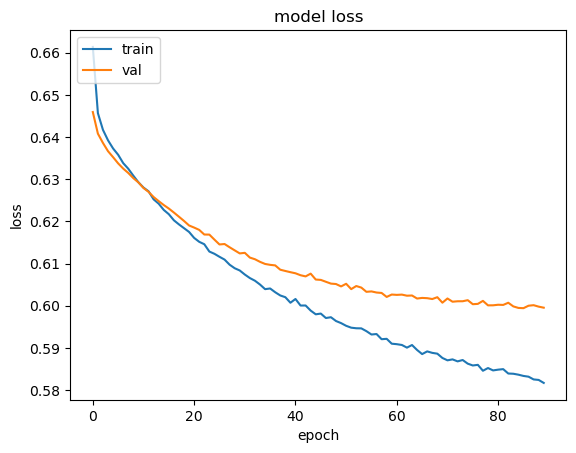

In [42]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

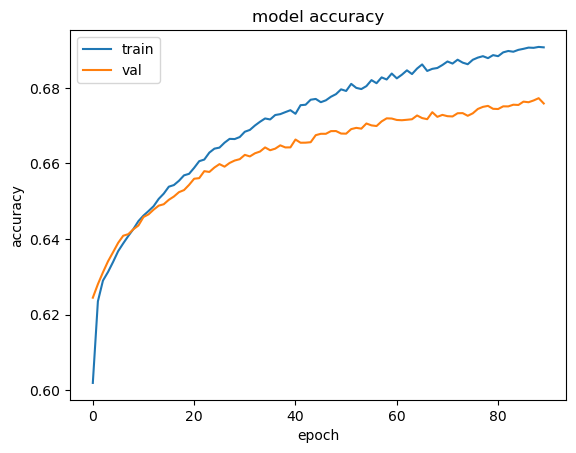

In [43]:
plt.plot(history.history['Accuracy'])
plt.plot(history.history['val_Accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

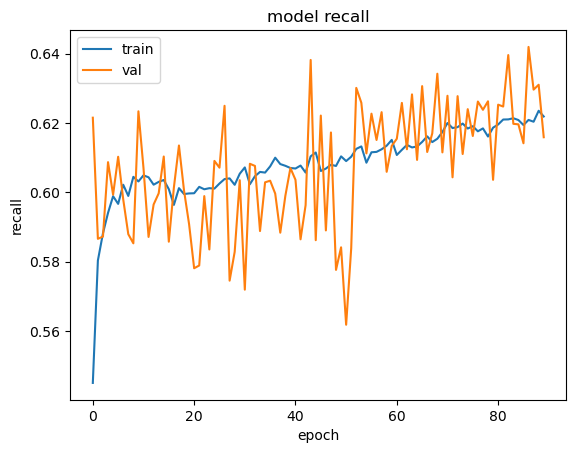

In [44]:
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

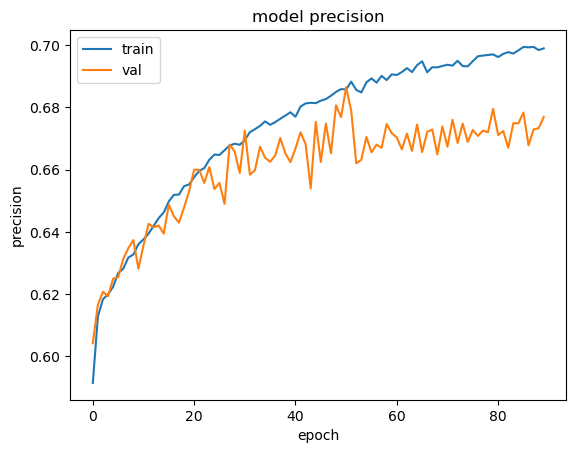

In [45]:
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [46]:
score_ann = model.evaluate(np.asarray(df_flights_test.iloc[:,1:]).astype('float32'),
                          np.asarray(df_flights_test.iloc[:,0]).astype('float32')) 

print('Test loss:', score_ann[0]) 
print('Test accuracy:', score_ann[1])
print('Test recall:', score_ann[2])
print('Test precision:', score_ann[3])

1006/1006 [==============================] - 9s 9ms/step - loss: 0.5983 - Accuracy: 0.6775 - recall: 0.6145 - precision: 0.6779
Test loss: 0.5983461141586304
Test accuracy: 0.6775125861167908
Test recall: 0.614520788192749
Test precision: 0.6778538227081299


In [47]:
predicted = model.predict(np.asarray(df_flights_test.iloc[:,1:]).astype('float32')) 

1006/1006 [==============================] - 4s 4ms/step


In [48]:
(predicted < 0.5).sum()/predicted.shape[0]*100

56.84940021132451

In [49]:
(predicted >= 0.5).sum()/predicted.shape[0]*100

43.15059978867549

In [50]:
model.save("./models/modelWeather.keras")

## KNN

In [52]:
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn.model_selection import cross_val_score

In [54]:
k_values = [i for i in range (10,41, 10)]
scores = []
X = np.asarray(df_flights_train_val.iloc[:,1:]).astype('float32')
y = np.asarray(df_flights_train_val.iloc[:,0]).astype('float32')


In [ ]:
for k in k_values:
    print(k)
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X, y, cv=5)
    scores.append(np.mean(score))

Text(0, 0.5, 'Accuracy Score')

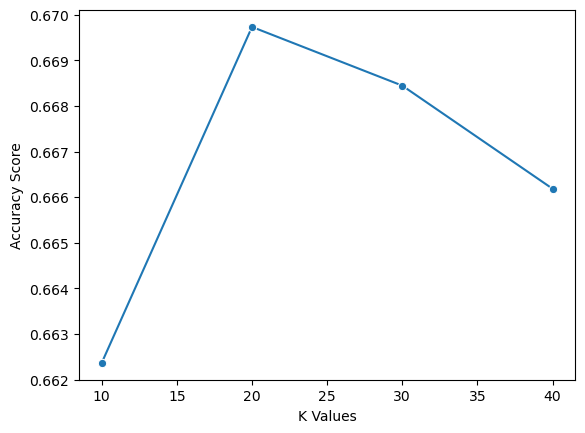

In [98]:
sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

In [55]:
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X, y)
y_pred = knn.predict(np.asarray(df_flights_test.iloc[:,1:]).astype('float32'))

In [56]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
accuracy = accuracy_score(np.asarray(df_flights_test.iloc[:,0]).astype('float32'), y_pred)
print("Accuracy:", accuracy)
accuracy = precision_score(np.asarray(df_flights_test.iloc[:,0]).astype('float32'), y_pred)
print("Precision:", accuracy)
accuracy = recall_score(np.asarray(df_flights_test.iloc[:,0]).astype('float32'), y_pred)
print("Recall:", accuracy)

Accuracy: 0.6569706010317609
Precision: 0.6627110908261068
Recall: 0.568816923478715


## Decision Tree

In [57]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

In [58]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy")

# Train Decision Tree Classifer
clf = clf.fit(X,y)

#Predict the response for test dataset
y_pred = clf.predict(np.asarray(df_flights_test.iloc[:,1:]).astype('float32'))

In [59]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(np.asarray(df_flights_test.iloc[:,0]).astype('float32'), y_pred))
print("Precision:",metrics.precision_score(np.asarray(df_flights_test.iloc[:,0]).astype('float32'), y_pred))
print("Recall:",metrics.recall_score(np.asarray(df_flights_test.iloc[:,0]).astype('float32'), y_pred))

Accuracy: 0.6318602772080303
Precision: 0.6147486772486772
Recall: 0.6068816923478715


# Prescriptive

Find optimal carrer to minizime delayes probability.
The weather forecast is not required, but in the output it will show which carrer with different weathers.

In [4]:
df_flights = pd.read_csv("./dataset/flights_integrated.csv", index_col = 0)

In [5]:
df_flights

,is_delayed,condition_Cloudy,condition_Cloudy / Windy,condition_Fair,condition_Fair / Windy,condition_Mostly Cloudy,condition_Mostly Cloudy / Windy,condition_Partly Cloudy,condition_Partly Cloudy / Windy,Wind,...,dest_TYS,dest_XNA,month_sin,month_cos,monthDay_sin,monthDay_cos,weekDay_sin,weekDay_cos,CRSDepTime_hour_sin,CRSDepTime_hour_cos
0,0,0,0,0,0,1,0,0,0,0.085714,...,0,0,5.000000e-01,0.866025,2.012985e-01,0.97953,0.781831,0.62349,1.000000,6.123234e-17
1,0,0,0,0,0,1,0,0,0,0.085714,...,0,0,5.000000e-01,0.866025,2.012985e-01,0.97953,0.781831,0.62349,1.000000,6.123234e-17
2,0,0,0,0,0,1,0,0,0,0.085714,...,0,0,5.000000e-01,0.866025,2.012985e-01,0.97953,0.781831,0.62349,1.000000,6.123234e-17
3,1,0,0,0,0,1,0,0,0,0.085714,...,0,0,5.000000e-01,0.866025,2.012985e-01,0.97953,0.781831,0.62349,1.000000,6.123234e-17
4,0,0,0,0,0,1,0,0,0,0.085714,...,0,0,5.000000e-01,0.866025,2.012985e-01,0.97953,0.781831,0.62349,1.000000,6.123234e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321779,1,0,0,1,0,0,0,0,0,0.285714,...,0,0,-2.449294e-16,1.000000,-2.449294e-16,1.00000,0.781831,0.62349,-0.707107,7.071068e-01
321780,0,0,0,1,0,0,0,0,0,0.285714,...,0,0,-2.449294e-16,1.000000,-2.449294e-16,1.00000,0.781831,0.62349,-0.707107,7.071068e-01
321781,1,0,0,1,0,0,0,0,0,0.285714,...,0,0,-2.449294e-16,1.000000,-2.449294e-16,1.00000,0.781831,0.62349,-0.707107,7.071068e-01
321782,0,0,0,1,0,0,0,0,0,0.285714,...,0,0,-2.449294e-16,1.000000,-2.449294e-16,1.00000,0.781831,0.62349,-0.707107,7.071068e-01


In [14]:
Month = 1
DayMonth = 10
weekDay = 1
MinHour = 9
MaxHour = 17
Destination = "dest_DEN"

In [15]:
month_sin =  np.sin(2*np.pi*Month/12)
month_cos = np.cos(2*np.pi*Month/12)

monthDay_sin = np.sin(2*np.pi*DayMonth/31)
monthDay_cos = np.cos(2*np.pi*DayMonth/31)

weekDay_sin = np.sin(2*np.pi*weekDay/7)
weekDay_cos  = np.cos(2*np.pi*weekDay/7)

In [16]:
all_dest = df_flights.filter(regex='dest').columns
dummy_dest = []
for dest in all_dest:
    if(dest == Destination):
        dummy_dest.append(1)
    else:
        dummy_dest.append(0)

In [17]:
df_flights.columns[1:10]

Index(['condition_Cloudy', 'condition_Cloudy / Windy', 'condition_Fair',
       'condition_Fair / Windy', 'condition_Mostly Cloudy',
       'condition_Mostly Cloudy / Windy', 'condition_Partly Cloudy',
       'condition_Partly Cloudy / Windy', 'Wind'],
      dtype='object')

In [18]:
df_flights.columns[10:20]

Index(['carrier_AA', 'carrier_AS', 'carrier_CO', 'carrier_DL', 'carrier_HP',
       'carrier_MQ', 'carrier_NW', 'carrier_TW', 'carrier_UA', 'carrier_US'],
      dtype='object')

In [19]:
#possible weather conditions
all_conds = df_flights.filter(regex='condition').columns
weathers = []
for i in range(0, len(all_conds)):
    dummy_conds = []
    target_cond = all_conds[i]
    for cond in all_conds:
        if(cond == target_cond):
            dummy_conds.append(1)
        else:
            dummy_conds.append(0)
        medianWind = np.median(df_flights[df_flights[target_cond]==1]["Wind"].values)
    dummy_conds.append(medianWind)
    weathers.append((target_cond, dummy_conds))
    

In [20]:
weathers

[('condition_Cloudy', [1, 0, 0, 0, 0, 0, 0, 0, 0.2857142857142857]),
 ('condition_Cloudy / Windy', [0, 1, 0, 0, 0, 0, 0, 0, 0.6571428571428571]),
 ('condition_Fair', [0, 0, 1, 0, 0, 0, 0, 0, 0.2571428571428571]),
 ('condition_Fair / Windy', [0, 0, 0, 1, 0, 0, 0, 0, 0.6]),
 ('condition_Mostly Cloudy', [0, 0, 0, 0, 1, 0, 0, 0, 0.2857142857142857]),
 ('condition_Mostly Cloudy / Windy',
  [0, 0, 0, 0, 0, 1, 0, 0, 0.6285714285714286]),
 ('condition_Partly Cloudy', [0, 0, 0, 0, 0, 0, 1, 0, 0.2571428571428571]),
 ('condition_Partly Cloudy / Windy',
  [0, 0, 0, 0, 0, 0, 0, 1, 0.6571428571428571])]

In [21]:
model = tf.keras.models.load_model("./models/modelWeather.keras")

In [22]:
dfResult = pd.DataFrame(columns = ["Carrier", "Hour", "Weather_condition", "Wind", "isDelayedP", "isDelayed"])
all_carrier = df_flights.filter(regex='carrier').columns
cont_carrier = 0
lenDf = 0
for carrier in all_carrier:
    dummy_carrier = []
    for i in range(0, len(all_carrier)):
        if(i == cont_carrier):
            dummy_carrier.append(1)
        else:
            dummy_carrier.append(0)
    for hour in range(MinHour, MaxHour):
        CRSDepTime_hour_sin = np.sin(2*np.pi*hour/24)
        CRSDepTime_hour_cos = np.cos(2*np.pi*hour/24)
        for weather in weathers:
            #build input
            input_model = weather[1]
            input_model = np.append(input_model, dummy_carrier) 
            input_model = np.append(input_model, dummy_dest) 
            input_model = np.append(input_model, [month_sin, month_cos,monthDay_sin,monthDay_cos,weekDay_sin, 
                                                  weekDay_cos, CRSDepTime_hour_sin, CRSDepTime_hour_cos ])
            isDelayedP = model.predict(input_model[None, :] .astype('float32'))[0][0]
            isDelayed = 0
            if(isDelayedP >= 0.50):
                isDelayed = 1
            dfResult.loc[lenDf] = [carrier, hour, weather[0], weather[1][8], isDelayedP, isDelayed]
            lenDf+=1
            
    cont_carrier += 1

1/1 [==============================] - 0s 14ms/step


In [23]:
dfResult

,Carrier,Hour,Weather_condition,Wind,isDelayedP,isDelayed
0,carrier_AA,9,condition_Cloudy,0.285714,0.327489,0
1,carrier_AA,9,condition_Cloudy / Windy,0.657143,0.293551,0
2,carrier_AA,9,condition_Fair,0.257143,0.298546,0
3,carrier_AA,9,condition_Fair / Windy,0.600000,0.294212,0
4,carrier_AA,9,condition_Mostly Cloudy,0.285714,0.309398,0
...,...,...,...,...,...,...
635,carrier_US,16,condition_Fair / Windy,0.600000,0.728178,1
636,carrier_US,16,condition_Mostly Cloudy,0.285714,0.283403,0
637,carrier_US,16,condition_Mostly Cloudy / Windy,0.628571,0.511521,1
638,carrier_US,16,condition_Partly Cloudy,0.257143,0.275051,0


In [24]:
print("General percentage of delayed flights:")
(dfResult["isDelayed"] == 1).sum()/dfResult.shape[0]*100

General percentage of delayed flights:


14.531250000000002

In [25]:
# For each weather condition find the best flight
for weather in dfResult["Weather_condition"].unique():
    print("************** " + weather)
    print("Carrier: " + dfResult.loc[dfResult[dfResult["Weather_condition"] == weather]["isDelayedP"].idxmin()].Carrier)
    print("Hour: " + str(dfResult.loc[dfResult[dfResult["Weather_condition"] == weather]["isDelayedP"].idxmin()].Hour))

************** condition_Cloudy
Carrier: carrier_NW
Hour: 9
************** condition_Cloudy / Windy
Carrier: carrier_CO
Hour: 9
************** condition_Fair
Carrier: carrier_CO
Hour: 13
************** condition_Fair / Windy
Carrier: carrier_NW
Hour: 10
************** condition_Mostly Cloudy
Carrier: carrier_NW
Hour: 12
************** condition_Mostly Cloudy / Windy
Carrier: carrier_CO
Hour: 9
************** condition_Partly Cloudy
Carrier: carrier_NW
Hour: 15
************** condition_Partly Cloudy / Windy
Carrier: carrier_CO
Hour: 9


In [26]:
# For each weather condition find the best flight
for weather in dfResult["Weather_condition"].unique():
    print("************** " + weather)
    print("Carrier: " + dfResult.loc[dfResult[dfResult["Weather_condition"] == weather]["isDelayedP"].idxmax()].Carrier)
    print("Hour: " + str(dfResult.loc[dfResult[dfResult["Weather_condition"] == weather]["isDelayedP"].idxmax()].Hour))

************** condition_Cloudy
Carrier: carrier_MQ
Hour: 9
************** condition_Cloudy / Windy
Carrier: carrier_MQ
Hour: 13
************** condition_Fair
Carrier: carrier_MQ
Hour: 11
************** condition_Fair / Windy
Carrier: carrier_MQ
Hour: 16
************** condition_Mostly Cloudy
Carrier: carrier_MQ
Hour: 10
************** condition_Mostly Cloudy / Windy
Carrier: carrier_MQ
Hour: 11
************** condition_Partly Cloudy
Carrier: carrier_MQ
Hour: 9
************** condition_Partly Cloudy / Windy
Carrier: carrier_MQ
Hour: 9
